In [ ]:
from pyspark.sql import SparkSession
import pyarrow

# Create a Spark session
spark = SparkSession.builder.appName("kaggle_eegs").getOrCreate()
spark.conf.set("spark.sql.execution.arrow.enabled")



In [ ]:
file_path = '/home/harraz/my_tensorflow/venv/eegs/training_data/train.csv'

# Read labels CSV file into a DataFrame
train_y = spark.read.csv(file_path, header=True, inferSchema=True)

# Show the DataFrame
train_y.show(10)


In [ ]:
from pyspark.sql import DataFrame

file_path = '/home/harraz/my_tensorflow/venv/eegs/training_data/*.parquet'

# Read parquet file into a DataFrame
train_X = spark.read.parquet(file_path, inferSchema=False)


In [ ]:
train_X.show(5)

In [57]:
from pyspark.sql.functions import when

train_Labels = train_y.withColumn('expert_consensus', when(train_y['expert_consensus'] == 'Seizure', 1).otherwise(0))
train_Labels = train_Labels.select(train_Labels.expert_consensus).limit(500000)
train_Labels.show(5)

+----------------+
|expert_consensus|
+----------------+
|               1|
|               1|
|               1|
|               1|
|               1|
+----------------+
only showing top 5 rows



In [ ]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.linalg import VectorUDT
from pyspark.sql.functions import col
# from pyspark.sql.types import DoubleType

# List of feature columns
feature_columns = ['Fp1', 'F3', 'C3', 'P3', 'F7', 'T3', 'T5', 'O1', 'Fz', 'Cz', 'Pz', 'Fp2', 'F4', 'C4', 'P4', 'F8', 'T4', 'T6', 'O2', 'EKG']

# Create a VectorAssembler
# assembler = VectorAssembler(inputCols=feature_columns, outputCol="features_assembled")
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features_assembled", handleInvalid="skip")

# Apply VectorAssembler to the training data
train_X_assembled = assembler.transform(train_X)

# Cast the features_assembled column to VectorUDT
train_X_assembled = train_X_assembled.withColumn("features_assembled", col("features_assembled").cast(VectorUDT()))

# Create a StandardScaler
scaler = StandardScaler(inputCol="features_assembled", outputCol="normalized_features", withStd=True, withMean=True)

# Fit the StandardScaler on the training data
scaler_model = scaler.fit(train_X_assembled)

# Transform the training data
train_X_scaled = scaler_model.transform(train_X_assembled)

# Display the scaled features
train_X_scaled.select("normalized_features").show(truncate=False)


In [ ]:
# Write the DataFrame to a Parquet file
# train_X_scaled.write.parquet("/home/harraz/my_tensorflow/venv/eegs/training_data/train_X_scaled.parquet")


In [58]:
train_X_scaled = spark.read.parquet("/home/harraz/my_tensorflow/venv/eegs/training_data/train_X_scaled.parquet")
train_X_scaled = train_X_scaled.select('normalized_features').limit(500000)
train_X_scaled.printSchema()

root
 |-- normalized_features: vector (nullable = true)



In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, FloatType, DoubleType
from pyspark.ml.linalg import VectorUDT

# Assuming "normalized_features" is a VectorUDT
vector_to_array_udf = udf(lambda v: v.toArray().tolist(), ArrayType(FloatType()))

# Apply the UDF to convert "normalized_features" to an array
train_X_scaled = train_X_scaled.withColumn("normalized_features_array", vector_to_array_udf("normalized_features"))

train_X_scaled =train_X_scaled.drop('normalized_features')
# Now, you can use the array as needed, and potentially convert it to a NumPy array
train_X_scaled.show(3)


In [ ]:
import numpy as np

# Assuming train_X_scaled_np and train_Labels are PySpark DataFrames
# Convert them directly to NumPy arrays
train_X_scaled_np = np.array(train_X_scaled.collect())
train_Labels_np = np.array(train_Labels.collect())

In [ ]:
print(train_X_scaled_np.shape)
print(train_Labels_np.shape)

In [59]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)
# build keras model with optimizer and 3 layer NN
def build_model():
  model = keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(1, 20)),  # Adjust the input shape
    # tf.keras.layers.GlobalAveragePooling1D(input_shape=(1, 20)),  # Replace Flatten with GlobalAveragePooling1D
    layers.Dense(300, activation=tf.nn.relu),
    layers.Dense(200, activation=tf.nn.relu),
    layers.Dense(1, activation=tf.nn.sigmoid)
  ])

  # optimizer = tf.keras.optimizers.RMSprop(0.05)

  # model.compile(loss='mse',
  #               optimizer=optimizer,
  #               metrics=['mse','mae'])
  
  model.compile(loss='binary_crossentropy', 
                optimizer='adam', 
                metrics=['accuracy'], )

  # model.compile(loss=keras.losses.mean_absolute_error,
  #               optimizer=keras.optimizers.SGD(0.4),
  #               metrics=['accuracy'])

  return model

model=build_model()
model.summary()
# keras.utils.plot_model(model, "hd_model.png", show_shapes=True)

EPOCHS = 100
early_stop = keras.callbacks.EarlyStopping(monitor='accuracy', patience=10)
history = model.fit(
    x=train_X_scaled_np, y=train_Labels_np, batch_size=100, epochs=EPOCHS, verbose=1,
    callbacks=[early_stop], validation_split=0.2, validation_data=None, shuffle=True,
    class_weight=None, sample_weight=None, initial_epoch=0, steps_per_epoch=None,
    validation_steps=None, validation_batch_size=None, validation_freq=1,
    max_queue_size=10, workers=2, use_multiprocessing=True
)


2.15.0
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_10 (Flatten)        (None, 20)                0         
                                                                 
 dense_39 (Dense)            (None, 300)               6300      
                                                                 
 dense_40 (Dense)            (None, 200)               60200     
                                                                 
 dense_41 (Dense)            (None, 1)                 201       
                                                                 
Total params: 66701 (260.55 KB)
Trainable params: 66701 (260.55 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
800/800 [==============================] - 20s 23ms/step - loss: 0.4970 - accuracy: 0.8033 - val_loss: 0.4725 - val_accuracy: 0.

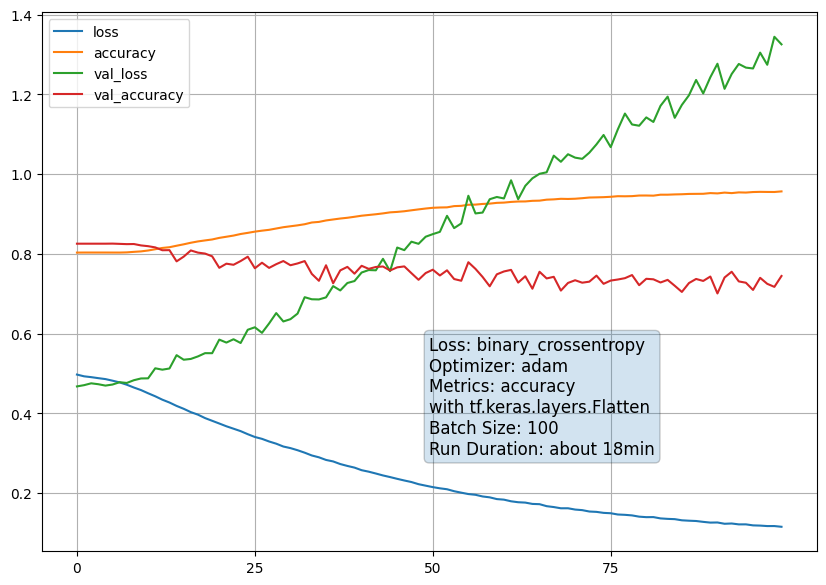

In [56]:
# To plot pretty figures
import pandas as pd
# import matplotlib as mpl
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(10, 7))
plt.grid(True)

# Add model parameters as text to the plot
model_params_text = (
    f"Loss: {'binary_crossentropy'}\n"
    f"Optimizer: {'adam'}\n"
    f"Metrics: {'accuracy'}\n" \
        f"with tf.keras.layers.Flatten\nBatch Size: 100\nRun Duration: about 18min\nWorkers:2\nRows: 500k" 
)

plt.text(0.5, 0.4, model_params_text, transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', alpha=0.2))

# plt.gca().set_ylim(0, 1)
plt.xticks(np.arange(0, 100, 25))
plt.show()

In [ ]:
# from pyspark.sql.types import StructType, StructField, DoubleType

# # Define the schema struct with DoubleType
# schema_struct_double = StructType([
#     StructField("Fp1", DoubleType(), True),
#     StructField("F3", DoubleType(), True),
#     StructField("C3", DoubleType(), True),
#     StructField("P3", DoubleType(), True),
#     StructField("F7", DoubleType(), True),
#     StructField("T3", DoubleType(), True),
#     StructField("T5", DoubleType(), True),
#     StructField("O1", DoubleType(), True),
#     StructField("Fz", DoubleType(), True),
#     StructField("Cz", DoubleType(), True),
#     StructField("Pz", DoubleType(), True),
#     StructField("Fp2", DoubleType(), True),
#     StructField("F4", DoubleType(), True),
#     StructField("C4", DoubleType(), True),
#     StructField("P4", DoubleType(), True),
#     StructField("F8", DoubleType(), True),
#     StructField("T4", DoubleType(), True),
#     StructField("T6", DoubleType(), True),
#     StructField("O2", DoubleType(), True),
#     StructField("EKG", DoubleType(), True)
# ])
# # Use the VectorAssembler with explicit input and output columns
# assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
# train_X = assembler.transform(train_X)


In [ ]:
import tensorflow as tf

# Initialize a GlobalAveragePooling1D (GAP1D) layer
gap1d_layer = tf.keras.layers.GlobalAveragePooling1D()

# Define sample array
sample_array = np.array([[[10,2],[1,3],[1,1]]])

# Print shape and contents of sample array
print(f'shape of sample_array = {sample_array.shape}')
print(f'sample array: {sample_array}')

# Pass the sample array to the GAP1D layer
output = gap1d_layer(sample_array)

# Print shape and contents of the GAP1D output array
print(f'output shape of gap1d_layer: {output.shape}')
print(f'output array of gap1d_layer: {output.numpy()}')